In [1]:

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from data_processing.neural_networks.RL_Reinforced_Learning.RL_funcs import (argmax_random_choice, plot_cliff_walking, rew_ep_plot);
from IPython.display import clear_output
clear_output()
from misc_tools.print_latex import print_tex
plt.rcParams['figure.figsize'] = [4, 2]

import numpy as np
from collections import defaultdict
import gym
import matplotlib.pyplot as plt


input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

# Eligibility Traces ($\lambda$)
*   n-step methods delay evaluation for n steps. We can call it _backward view_. In extreme they converge into Monte-Carlo method
    $$G_{t:t+n} \dot = R_{t+1}+ \gamma R_{t+2} + \dots +  \gamma^{n-1} R_{t+n} + \gamma^n \hat v_{t+n -1}(S_{t+n}, \vec{w}_{t+n-1})$$
*   One may construct a target by creating a _compound return_, which is a weighted sum (average) of different n-step returns.

    For example an average of 2-step and 4-step return:
    $$\frac{1}{2} G_{t:t+2} + \frac{1}{2} G_{t:t+4}$$
    We may ask for sum of weights to be 1, as to signify the importance of each n-step return
*   We can sum all 'partial' returns $G_{t:t+p}$ from sequence on rewards of $n$ steps with 'decaying' weights that are proportional to $\lambda^{n-1}$ $(\lambda \in [0,1])$

    For these weights to work, we have to normalize each by $(1-\lambda)$
    $$\boxed{G_n^\lambda = (1-\lambda)\sum_{n=1}^\infty \lambda^{n-1} G_{t:t+n}} $$
    ***
    Weight normalization:
    $$\sum_{n=1}^\infty \lambda^{n-1}  = \lambda^0 + \lambda^1+\dots = \sum_{n=0}^\infty \lambda^{n}$$
    Geometric series:
    $$\sum_{n=0}^\infty a r^n = \frac{a}{1-r} \rightarrow \sum_{n=1}^\infty \lambda^{n-1} = \sum_{n=0}^\infty \lambda^{n} = \frac{1}{1- \lambda} \cdot$$
    $$\sum_{n=0}^\infty \lambda^{n} = \frac{1}{1- \lambda} \cdot \bigg| (1- \lambda)  \longrightarrow \boxed{(1- \lambda) \sum_{n=1}^\infty \lambda^{n-1}= 1}$$
    ***
*   $\lambda$ methods work in reverse 

On termination step $T$:
$$t+n_T = T \rightarrow n_T = T - t$$
$$\lambda^{n_T-1} G_{t:t+n_T}  = \lambda^{T- t -1} G_{t:T} = \lambda^{T- t -1} G_t $$
We can split $G_t^\lambda $ into two terms
$$G_t^\lambda = (1-\lambda)\sum_{n=1}^\infty \lambda^{n-1} G_{t:t+n} = (1-\lambda)\sum_{n=1}^{n_T - 1 = (T - t) - 1}\lambda^{n-1} G_{t:t+n} + (1-\lambda)\sum_{n= n_T = T - t}^\infty \lambda^{n-1} G_{t:t+n}$$
*   _Im not sure what happens to second term past termination state. $ G_{t:T} = G_{t:T + 1} = G_t$?_
*   _if we terminate sum past $T$ then right term should be $(1-\lambda) \cdot \lambda^{T- t -1} G_t$. Why in the book its only $\lambda^{T- t -1} G_t$?_

Anyway, result in the book is:
$$\boxed{G_t^\lambda = (1-\lambda)\sum_{n=1}^{(T - t) - 1}\lambda^{n-1} G_{t:t+n} + \lambda^{T- t -1} G_t}$$
Which shows that in case of $\lambda = 1$
$$G_t^{\lambda = 1} = 0\cdot \sum_{n=1}^{(T - t) - 1}G_{t:t+n} + 1^{T-t-1} \cdot G_t = G_t$$
which i a Monte Carlo return. And if $\lambda = 0$
$$G_t^{\lambda=0} = 1\cdot [ 0^0 \cdot G_{t:t+1} + 0^1 \cdot G_{t:t+2} + \dots] + 0^{T-t-1} \cdot  G_t = G_{t:t+1} + 0 + \dots$$

so we see that extreme values of $\lambda$ change composite return to either TD(0) or MC returns:
*   $G_t^{\lambda = 1} = G_t$
*   $G_t^{\lambda = 0} = G_{t:t+1}$


In [90]:
class env_approx():
    def __init__(self, env_name, state_embeddings = None,  eps = 0.1, ALPHA = 0.05, GAMMA = 1, *args, **kwargs) -> None:
        """     grad_Qsa() and grad_Vs() are defined for linear approximation.
                Qsa() and/or Vs() can eval slices of data instead of one action/state.
                Since we use eps-greedy i store only greedy values and roll it vs remaining eps. 
                init_policy_entries() makes eps-greedy policy for all actions. ~{0:[1-eps, eps/2, eps/2],...}.
        """
        self.env                    = gym.make(env_name, *args, **kwargs)
        # if space is multi-dimensional -> tuples of spaces
        if type(self.env.observation_space) == gym.spaces.tuple.Tuple:
            self.STATE_SHAPE        = tuple(map(lambda x: x.n, self.env.observation_space))
        else:
            self.STATE_SHAPE        = (self.env.observation_space.n,) 

        self.eps                    = eps
        self.NUM_ACTIONS            = self.env.action_space.n 
        self.NUM_STATES_TOTAL       = np.prod(self.STATE_SHAPE)
        self.STATE_SHAPE_EXTENDED   = self.STATE_SHAPE + (self.NUM_ACTIONS,)

        self.Wv                     = np.zeros(self.STATE_SHAPE)
        self.Wq                     = np.zeros((self.NUM_ACTIONS,) + self.STATE_SHAPE)

        if state_embeddings is None:
            self.Xs                 = np.eye(self.NUM_STATES_TOTAL)
        else:   
            self.Xs                 = state_embeddings
        self.actions                = np.arange(self.NUM_ACTIONS)

        self.policy_action          = np.zeros((self.NUM_ACTIONS,self.NUM_ACTIONS))
        self.policy                 = np.zeros(self.STATE_SHAPE, dtype = int)

        self.env_iters              = 0

        self.GAMMA  = GAMMA
        self.ALPHA = ALPHA
            

    def init_policy_entries(self):
        self.policy_action *= 0
        self.policy_action += self.eps/(self.NUM_ACTIONS)
        self.policy_action += np.eye(self.NUM_ACTIONS)*(1 - self.eps)

    def init_Qsa(self, random = False, action = None, val = 0.5):
        self.Wq *= 0
        if random:
            self.Wq += np.random.randn(*self.Wq.shape) 
        else:
            if action is not None:  self.Wq[action] += val
            else:                   self.Wq         += val
    
    def init_Vs(self, random = False, val = 0.5):
        self.Wv *= 0
        if random:  self.Wv += np.random.randn(*self.Wv.shape) 
        else:       self.Wv += val             

    def init_policy(self):
        self.policy = self.Qsa(self.actions, None).squeeze(1).argmax(0) # None = :

    def Qsa(self, action, state):
        # notice we can pass slices or masks in actions/states
        return np.dot(self.Wq[action], self.Xs[state])  
    
    def Vs(self,state):
        return np.dot(self.Wv, self.Xs[state])

    def update_V(self):
        self.Wv = self.Qsa(self.actions, None).squeeze(1).max(0)
        
    def grad_Qsa(self,action,state):
        return self.Xs[state]
    
    def grad_Vs(self,state):
        return self.Xs[state]
    
    def update_Wq(self, step_size, target, state, action):
        self.Wq[action] += step_size*(target - self.Qsa(action,state))*self.grad_Qsa(self,action,state)

    def update_Wv(self, step_size, target, state):
        self.Wv += step_size*(target - self.Vs(state))*self.grad_Vs(self,state)
    
    def sample_action(self, state, use_Qsa = True):
        best_action = argmax_random_choice(self.Qsa(self.actions,state)) if use_Qsa else self.policy[state]
        return np.random.choice(self.actions, p= self.policy_action[best_action])

    def state_remap(self,state):
        if type(state) !=int and len(state) > 1:  return tuple(map(int,state))
        else:               return (int(state),)
    
    def reset(self):
        state = self.env.reset()[0]
        return self.state_remap(state)
    
    def step(self, action):
        state, reward, done = self.env.step(action)[:3]
        state               = self.state_remap(state)
        return state, reward, done


# Semi-gradient TD($\lambda$) for estimating $\hat v \approx v_\pi$
Eligibility trace vector holds history visited states. 

Vectors shape is the same as the shape of f-n approximation parameters, each entries is relate to state or states.

$$ \boxed{\vec{z}_t = \gamma \lambda \vec{z}_{t-1} + \nabla_w \hat v(S_t, \vec{w}_t)}$$

Expression has two parts:
1.  term $\nabla_w \hat v(S_t, \vec{w}_t)$ shows which v approximation parameters (might think which states) are relevant/active now. Assign these entries (~)non-zero values.

2. term $\gamma \lambda \vec{z}_{t-1}$ holds a history. Values of $z$ decay as $\lambda$ each iteration

Overall $z$ holds amplitudes of most 'active' parameters/states at current trajectories step.

function approximation weights are then updated using this history

$$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \delta_t \vec{z}_{t}}$$
where $\delta_t$ is an (TD) error

$$\delta_t = R_{t+1} + \gamma \hat v(S_{t+1}, \vec{w}_t) - \hat v(S_{t}, \vec{w}_t) $$

one can see, that this way updates to weights 'persist' through iterations.

if $\lambda = 0$, TD($\lambda$) weight update reduces to TD(0) approach _(not a naming coincidence)_:
$$\vec{w}_{t+1} = \vec{w}_{t} + \alpha \delta_t \nabla_w \hat v(S_t, \vec{w}_t)$$

if $0 \lt \lambda \lt 1$ more states in trajectory 'take credit' for TD error

if $\lambda = 1$ Monte Carlo behavior is achieved and algorithm is named... TD(1)

In [91]:
class TD_Lambda(env_approx):
    def __init__(self, env_name, state_embeddings=None,  eps=0.1, ALPHA=0.05, LAMBDA=0.5, GAMMA=1, *args, **kwargs) -> None:
        super().__init__(env_name, state_embeddings,  eps=eps, ALPHA=ALPHA, GAMMA=GAMMA, *args, **kwargs)
        self.z = np.zeros_like(self.Wv)
        self.states = []
        self.rewards = []
        self.LAMBDA = LAMBDA

    def update_z(self,state):
        self.z  = self.GAMMA*self.LAMBDA * self.z + self.grad_Vs(state)

    def target(self, reward, state, state_next):
        return reward +  self.GAMMA *self.Vs(state_next) - self.Vs(state)

    def update_Wv(self, step_size, delta):
        self.Wv += step_size*delta*self.z        

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1000/1000 [00:04<00:00, 216.23it/s]


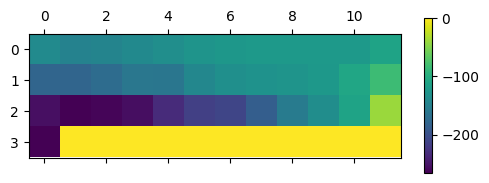

In [92]:
def TD_Lambda_Loop(env: TD_Lambda, N = 1):
    
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state           = env.reset()    
        env.z *= 0                   
        while True:
            At = env.sample_action(state, use_Qsa=False)  
            state_next, reward, terminal   = env.step(At)
            env.update_z(state)
            delta = env.target(reward,state, state_next)
            env.update_Wv(env.ALPHA,delta)
            state = state_next
            if terminal: break
    return 


env = TD_Lambda("CliffWalking-v0", eps=0.4)
env.init_policy_entries()
env.init_Qsa(False, action=1)
env.Wq[:,36] = [0.5,0,0,0]  # start- up
env.Wq[:,-1] *= 0           # terminal rew 0
env.init_policy()
env.Wq[:,36],env.sample_action(36)
env.update_V()

TD_Lambda_Loop(env, N = 1000)
c = plt.matshow(env.Vs(None).reshape(4,12))
plt.colorbar(c)

# True online TD($\lambda$) for estiamating $\vec{w}^T \vec{x} \approx v_\pi$
Well... Roughly speaking we want update weights in online manner, but still want to do n-step updates. We can unfold n-step updates and as new information is available re-calculate/update old calculation with estimator using most recent weights...

$$\vec{z}_t = \gamma \lambda \vec{z}_{t-1} + (1 - \alpha \gamma \lambda \vec{z}_{t-1}^T \vec{x}_t)\vec{x}_t$$

$$\vec{w}_{t+1} = \vec{w}_t + \alpha \delta_t \vec{z}_{t} + \alpha(\vec{w}_{t}^T \vec{x}_t - \vec{w}_{t-1}^T\vec{x}_t)\cdot (\vec{z}_{t}-\vec{x}_{t})$$

  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1000/1000 [00:05<00:00, 189.78it/s]


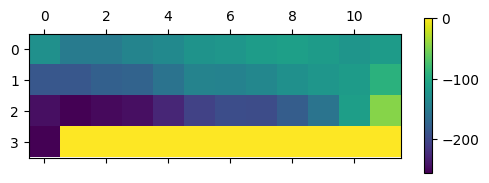

In [93]:
class True_online_TD_Lambda(env_approx):
    def __init__(self, env_name, state_embeddings=None, eps=0.1, ALPHA=0.05,LAMBDA = 0.5, GAMMA=1, *args, **kwargs) -> None:
        super().__init__(env_name, state_embeddings, eps, ALPHA, GAMMA, *args, **kwargs)
        self.z = np.zeros_like(self.Wv)
        self.LAMBDA     = LAMBDA
        self.GL         = self.GAMMA*LAMBDA
        self.AGL        = self.ALPHA*self.GAMMA*LAMBDA
        self.V, self.Vp = 0,0
        self.delta      = 0
        self.states,   self.rewards = [], []

    def update_z(self,state):
        zTx = np.dot(self.z, self.Xs[state])
        self.z  = self.GL * self.z + (1 - self.AGL*zTx)*self.grad_Vs(state)

    def target(self, reward, state, state_next):
        self.V  = self.Vs(state)
        self.Vp = self.Vs(state_next)
        self.delta = reward + self.GAMMA *self.Vp - self.V

    def update_Wv(self, state, V_old):
        self.Wv +=  self.ALPHA*(self.delta + self.V - V_old)*self.z - \
                    self.ALPHA*(self.V - V_old)*self.Xs[state]
        
    
def True_online_TD_Lambda_Loop(env: True_online_TD_Lambda, N = 1):
    
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state           = env.reset()    
        env.z *= 0  
        V_old = 0                 
        while True:
            At = env.sample_action(state, use_Qsa=False)  
            state_next, reward, terminal   = env.step(At)
            env.target(reward, state, state_next)
            env.update_z(state)
            env.update_Wv(state, V_old)
            V_old = env.Vp
            state = state_next
            if terminal: break
    return 

env = True_online_TD_Lambda("CliffWalking-v0", eps=0.4)
env.init_policy_entries()
env.init_Qsa(False, action=1)
env.Wq[:,36] = [0.5,0,0,0]  # start- up
env.Wq[:,-1] *= 0           # terminal rew 0
env.init_policy()
env.update_V()


True_online_TD_Lambda_Loop(env, N = 1000)

c = plt.matshow(env.Vs(None).reshape(4,12))
plt.colorbar(c)

# Sarsa($\lambda$) with binary features an lin f-n approx $q_\pi \approx \vec{w}^T\vec{x}$ or $q_\ast$

In [98]:
class SARSA_Lambda(env_approx):
    def __init__(self, env_name, state_embeddings=None, eps=0.1, ALPHA=0.05,LAMBDA = 0.5, GAMMA=1, *args, **kwargs) -> None:
        super().__init__(env_name, state_embeddings, eps, ALPHA, GAMMA, *args, **kwargs)
        self.z = np.zeros_like(self.Wq)
        self.LAMBDA     = LAMBDA
        self.GL         = self.GAMMA*LAMBDA
        self.AGL        = self.ALPHA*self.GAMMA*LAMBDA
        self.V, self.Vp = 0,0
        self.Xs = self.Xs.astype(int)
        self.delta      = 0
        self.states,   self.rewards = [], []

    def update_z(self):
        self.z  *= self.GL

    def update_Wq(self, delta):
        self.Wq += self.ALPHA*delta*self.z 
        
    
def SARSA_Lambda_Loop(env: True_online_TD_Lambda, N = 1):
    
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state           = env.reset()   
        action = env.sample_action(state, use_Qsa=True)  
        env.z *= 0  
        while True:
            state_next, reward, terminal   = env.step(action)
            delta = reward
            delta += env.Qsa(action, state)
            env.z[action, env.Xs[state]] += 1
            if terminal: 
                env.Wq += env.ALPHA*delta*env.z
                break
            action_next = env.sample_action(state_next, use_Qsa=True)  
            delta += env.GAMMA*env.Qsa(action_next, state_next)

            env.update_z()
            env.update_Wq(state, delta)

            state = state_next
            action_next = action
            
    return 

env = SARSA_Lambda("CliffWalking-v0", eps=0.4)
env.init_policy_entries()
env.init_Qsa(False, action=1)
env.Wq[:,36] = [0.5,0,0,0]  # start- up
env.Wq[:,-1] *= 0           # terminal rew 0
env.init_policy()
env.update_V()


SARSA_Lambda_Loop(env, N = 1)

c = plt.matshow(env.Vs(None).reshape(4,12))
plt.colorbar(c)

  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 0/1 [00:00<?, ?it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0]


TypeError: update_Wq() takes 2 positional arguments but 3 were given

In [127]:
env_CW_SARSA_L = base_env("CliffWalking-v0", eps=0.1)
env_CW_SARSA_L.Qsa_init(random=True)
env_CW_SARSA_L.Qsa[37:] *= 0

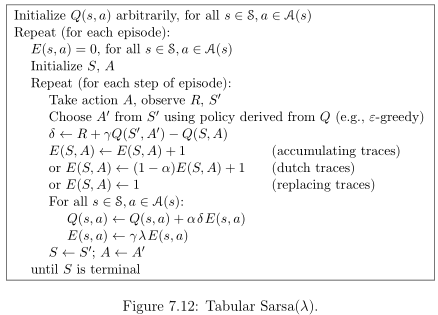

  0%|          | 0/300 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 300/300 [13:50<00:00,  2.77s/it, eps=0.1]        


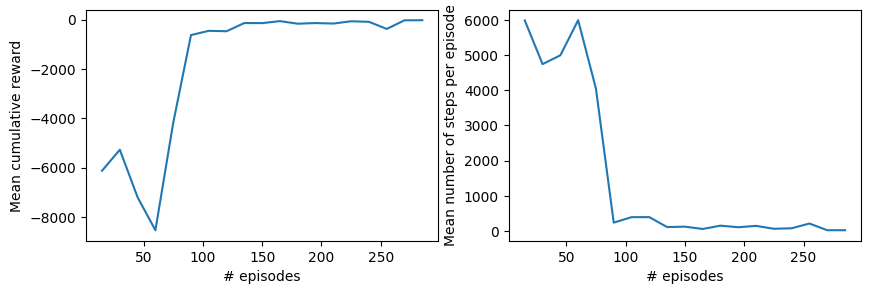

In [128]:
def sarsa_lambda(env: base_env, N = 1, GAMMA = 1, ALPHA = 0.01, LAMBDA = 0.2, trace_type = 1,
                 DPlays = 250_000, NPlays = 100, eps_cap = 0.1):
    
    if trace_type == 0: # accumulating
        trace_fn = lambda Esa: Esa + 1
    elif trace_type == 1: # dutch
        trace_fn = lambda Esa: (1-ALPHA)*Esa + 1
    elif trace_type == 2: # replacing
        trace_fn = lambda Esa: 1

    tq_iter = tqdm(range(N))
    for i in tq_iter:
        Esa = np.zeros_like(env.Qsa)
        state           = env.reset()                       
        action          = env.sample_action(state, use_Qsa=True)  
        state_action    = state + (action,)
        s = 0
        while True:
            state_prime, reward, done   = env.step(action)
            action_prime                = env.sample_action(state_prime, use_Qsa=True)
            state_action_prime          = state_prime + (action_prime,)
            delta                       = reward + GAMMA*env.Qsa[state_action_prime] - env.Qsa[state_action]
            Esa[state_action]           = trace_fn(Esa[state_action])
            env.Qsa                     += ALPHA*delta*Esa
            Esa                         *= GAMMA*LAMBDA*Esa
            if done: break
            state, action               = state_prime, action_prime
            state_action                = state_action_prime
            s += 1
            tq_iter.set_postfix(eps=env.eps, s = s)
        
        if env.env_iters % DPlays == 0 and i > 0 and NPlays > 0:
            env.play_N_episodes(N=NPlays, use_Qsa=False)

        env.env_iters += 1
        
        env.eps = max(eps_cap, env.eps/ (env.env_iters**0.0002))
        tq_iter.set_postfix(eps=env.eps)
    return

sarsa_lambda(env_CW_SARSA_L, N = 300, GAMMA = 0.99, ALPHA = 0.1, LAMBDA=0.2, DPlays = 15, NPlays = 400, eps_cap = 0.1)
rew_ep_plot(env_CW_SARSA_L,0)

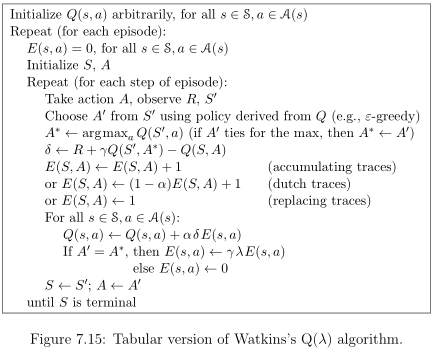

In [137]:
env_CW_QL_L = base_env("CliffWalking-v0", eps=0.1)
env_CW_QL_L.Qsa_init(random=True)
env_CW_QL_L.Qsa[37:] *= 0

  0%|          | 0/300 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 0/300 [00:00<?, ?it/s, eps=0.1, s=2]

100%|██████████| 300/300 [06:42<00:00,  1.34s/it, eps=0.1]        


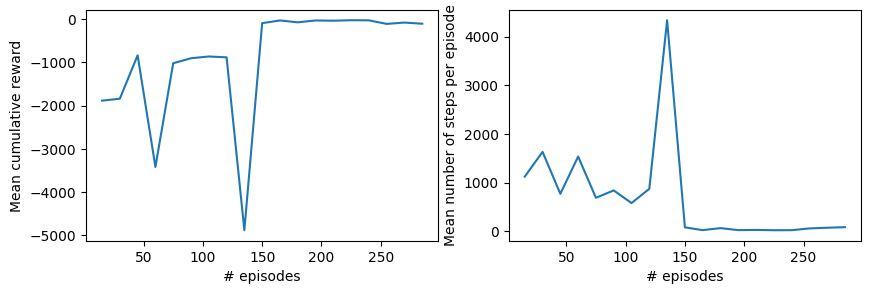

In [138]:
def Q_Learning_lambda(env: base_env, N = 1, GAMMA = 1, ALPHA = 0.01, LAMBDA = 0.2, trace_type = 1,
                 DPlays = 250_000, NPlays = 100, eps_cap = 0.1):
    
    if trace_type == 0: # accumulating
        trace_fn = lambda Esa: Esa + 1
    elif trace_type == 1: # dutch
        trace_fn = lambda Esa: (1-ALPHA)*Esa + 1
    elif trace_type == 2: # replacing
        trace_fn = lambda Esa: 1

    tq_iter = tqdm(range(N))
    for i in tq_iter:
        Esa = np.zeros_like(env.Qsa)
        state           = env.reset()                       
        action          = env.sample_action(state, use_Qsa=True)  
        state_action    = state + (action,)
        s = 0
        while True:
            state_prime, reward, done   = env.step(action)
            action_prime                = env.sample_action(state_prime, use_Qsa=True)
            state_action_prime          = state_prime + (action_prime,)
            action_star                 = env.sample_action(state_prime, use_Qsa=True, eps= 0.0) # not soft
            # 
            AAeq = int(env.Qsa[state_prime][action_prime] == env.Qsa[state_prime][action_star])
            delta                       = reward + GAMMA*env.Qsa[state_action_prime] - env.Qsa[state_action]
            Esa[state_action]           = trace_fn(Esa[state_action])
            env.Qsa                     += ALPHA*delta*Esa
            Esa                         *= AAeq*GAMMA*LAMBDA*Esa # 0 if not AAeq

            if done: break
            state, action               = state_prime, action_prime
            state_action                = state_action_prime
            s += 1
            tq_iter.set_postfix(eps=env.eps, s = s)
        
        if env.env_iters % DPlays == 0 and i > 0 and NPlays > 0:
            env.play_N_episodes(N=NPlays, use_Qsa=False)

        env.env_iters += 1
        
        env.eps = max(eps_cap, env.eps/ (env.env_iters**0.0002))
        tq_iter.set_postfix(eps=env.eps)
    return

Q_Learning_lambda(env_CW_QL_L, N = 300, GAMMA = 0.99, ALPHA = 0.1, LAMBDA=0.2, DPlays = 15, NPlays = 400, eps_cap = 0.1)
rew_ep_plot(env_CW_QL_L,0)

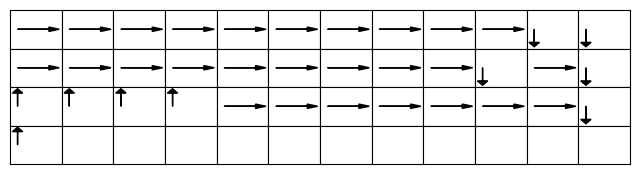

In [135]:
env_CW_QL_L.policy_update_whole(use_Qsa = True) 
env_CW_QL_L.policy[37:] *= 0
plot_cliff_walking(env_CW_QL_L.policy, figsize=(8,2))